In [44]:
import json

import blosc2
import h5py
import torch
from torch.utils.data import DataLoader, Dataset, random_split


This class provides some functionality for working with magnetic sources ('tiles') and their associated magnetic fields. They are pytorch tensors, compressed with blosc2 and HDF5. In this data set, the sources are prisms with varying positions, side lengths and magnetisations. They are all within a box of side length 10, and the magnetic field is evaluated at a 10 * 10 * 10 resolution.

In [41]:
class ConfigurationServer(Dataset):
    """Configuration server for training and validation. This subclasses a torch DataSet
    and adds a method for the loaders after splitting into training and validation."""

    def __init__(self, id, num_features=10):
        self.id = id
        self.num_features = num_features
        with h5py.File(f"config_{id}.h5", "r") as file:
            self.tiles = blosc2.unpack_tensor(file["tiles"][()])
            self.lens = blosc2.unpack_tensor(file["lens"][()])
            self.fields = blosc2.unpack_tensor(file["fields"][()])
        self.num_samples = len(self.tiles)
        self.N = int(len(self.tiles) * 0.8) # For train/test split
        self.tile_stats, self.field_stats = self.get_feature_stats()
    
    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, i):
        return (
            self.tiles[i, :, : self.num_features],
            self.lens[i],
            self.fields[i, :, :3],
            self.fields[i, :, 3:],
        )

    def print_tiles(self, tiles):
        return [
            {
                "position": tile[:3].tolist(),
                "size": tile[3:6].tolist(),
                "magnetisation": tile[6:9].tolist(),
                "shape": tile[9:].tolist(),
            }
            for tile in tiles
        ]

    def get_loaders(self, batch_size, num_workers):
        seed = torch.Generator().manual_seed(42)
        train_set, valid_set = random_split(
            self, [self.N, len(self) - self.N], generator=seed
        )
        train = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers)
        valid = DataLoader(valid_set, batch_size=batch_size, num_workers=num_workers)
        return train, valid

    def print_stats(self):  # pragma: no cover
        stats = dict(zip(["means", "stds"], self.print_tiles(self.tile_stats)))
        print(json.dumps(stats, indent=4))

    def get_feature_stats(self):
        tile_means = self.tiles.sum(dim=(0, 1)) / self.lens.sum()
        diff = (self.tiles - tile_means.unsqueeze(0).unsqueeze(0)) ** 2
        tile_stds = torch.sqrt(diff.sum(dim=(0, 1)) / self.lens.sum())
        field_means = self.fields.mean(dim=(0, 1))
        field_stds = self.fields.std(dim=(0, 1))
        return (
            (tile_means[: self.num_features], tile_stds[: self.num_features]),
            (field_means, field_stds),
        )

    def get_tile_stats(self):
        return (self.tile_stats[0], self.tile_stats[1])

    def get_field_stats(self):
        return (self.field_stats[0], self.field_stats[1])


In [42]:
id = "demo"
server = ConfigurationServer(id)


The batch dimension is first. Because there are *varying* numbers of sources in each sample, the tensor must be padded (with zeros). The `lens` tensor gives us the number of tiles in each sample; so, the sample with index 8 has 52 sources.

In [48]:
idx = 8
print(server.lens[idx])


tensor(52)


Each source has 10 values associated with it: a position 3-vector describing the centre of the prism, a length 3-vector describing the length of each side of the prism, a magnetisation 3-vector describing the magnetisation around that source. The last value can be ignored. 

In [49]:
print(server.tiles[idx])


tensor([[ 2.5000e+00,  8.5000e+00,  5.5000e+00,  8.1572e-01,  8.8472e-01,
          9.3349e-01, -5.7721e+05,  2.3325e+05, -7.2410e+05,  1.0000e+00],
        [ 6.5000e+00,  6.5000e+00,  6.5000e+00,  8.0678e-01,  9.6015e-01,
          9.1539e-01, -1.3325e+05, -3.8815e+05, -8.6225e+05,  1.0000e+00],
        [ 6.5000e+00,  4.5000e+00,  2.5000e+00,  9.4241e-01,  9.3975e-01,
          8.0710e-01,  2.7517e+05, -4.2480e+04,  9.1344e+05,  1.0000e+00],
        [ 9.5000e+00,  5.5000e+00,  7.5000e+00,  9.9920e-01,  9.9202e-01,
          9.8219e-01,  1.4630e+05, -6.3455e+05, -6.9845e+05,  1.0000e+00],
        [ 1.5000e+00,  7.5000e+00,  2.5000e+00,  9.2203e-01,  8.1282e-01,
          8.3381e-01, -3.5602e+05,  1.1472e+05,  8.7862e+05,  1.0000e+00],
        [ 5.5000e+00,  7.5000e+00,  5.0000e-01,  9.4395e-01,  8.7841e-01,
          9.3100e-01,  7.8608e+05, -3.8961e+05,  3.7705e+05,  1.0000e+00],
        [ 9.5000e+00,  5.0000e-01,  6.5000e+00,  8.6282e-01,  8.5439e-01,
          9.5489e-01,  3.7920e+0

The fields are 10 x 10 x 10 resolution, and each entry has six values: a 3-vector referring to the position at which the field measurement is made, and a 3-vector giving the magnetic field at that point.

In [50]:
print(server.fields[idx])


tensor([[ 7.3912e+00,  6.7414e+00,  1.3410e-02,  5.3936e+03, -1.0168e+04,
          1.6370e+04],
        [ 7.3247e+00,  3.1361e+00,  2.1602e+00,  7.8897e+04, -3.1247e+04,
          2.9818e+04],
        [ 1.2541e+00,  3.2688e+00,  1.6547e+00,  2.4474e+04,  1.4471e+03,
          6.5886e+03],
        ...,
        [ 9.5776e+00,  3.5679e+00,  4.6106e+00,  9.5164e+03, -9.2138e+03,
          4.4054e+03],
        [ 9.8738e-01,  6.8551e+00,  1.4375e+00,  1.8886e+05, -2.5753e+05,
         -3.2935e+04],
        [ 5.7874e+00,  1.2850e+00,  2.4761e+00,  3.4966e+04, -2.6694e+04,
         -6.1702e+03]])


Here is an image of how the sources and field vectors look. (This isn't implemented in the class above.)

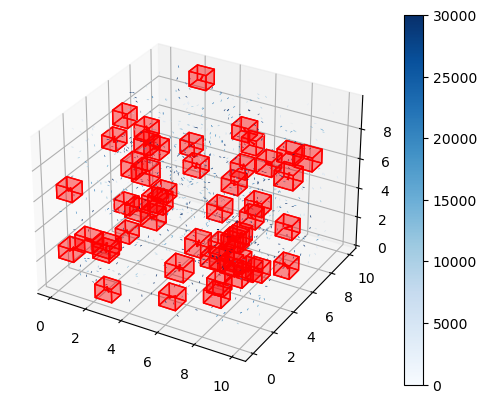

In [52]:
server.view(idx)


Finally, here are some aggregate statistics for the tiles and fields, across all the samples.

In [53]:
server.print_stats()


{
    "means": {
        "position": [
            4.999821662902832,
            4.9910197257995605,
            5.003429412841797
        ],
        "size": [
            0.8999398350715637,
            0.8999717831611633,
            0.8999239206314087
        ],
        "magnetisation": [
            -19647.263671875,
            -533.474853515625,
            28655.361328125
        ],
        "shape": [
            1.0
        ]
    },
    "stds": {
        "position": [
            5.705909729003906,
            5.698551654815674,
            5.708151340484619
        ],
        "size": [
            0.8893979787826538,
            0.8894272446632385,
            0.889380693435669
        ],
        "magnetisation": [
            469255.9375,
            507577.1875,
            658803.3125
        ],
        "shape": [
            0.9861972332000732
        ]
    }
}
